# SDC Ratio and SDC Impact

SDC ratio is a stable metrics. If fault injection campaign sample the same program many time and calculate the SDC ratio, for each campaign the SDC ratio will be the same.

SDC Impact is a unstable metrics. For each fault injection campaign program's expected SDC impact may change a lot.

In [55]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import iqr

In [88]:
cg_df = pd.read_csv("../static/data/cg_in8.csv")

dataset = 'cg'
#cg_df = pd.read_csv("../static/data/fft_exhaust.csv")

#highbit_dataset = cg_df[cg_df.bit > 32]
exp_dataset = cg_df[cg_df.bit > 52]
mantissa_dataset = cg_df[cg_df.bit < 53]

In [89]:
def sampleFunction(dataset, sample_size):
    return dataset.sample(n=sample_size)

def iteractiveSampleFunction(dataset, sample_size, filter_bit):
    filter_dataset = dataset[dataset.bit > filter_bit-1]
    return filter_dataset.sample(n=int(sample_size))

def iteractiveSampling(dataset, sample_size, iteration=10):
    sample_size_each_iter = sample_size/iteration
    sample = []
    
    mantissa_lowest_SDC_bit = 1
    mantissa_highest_bit = 52
    lowest_SDC_bit = 0
    
    for i in range(iteration):
        
        current_iter_sample = iteractiveSampleFunction(dataset, sample_size_each_iter, mantissa_lowest_SDC_bit)
        current_lowest_SDC_bit = current_iter_sample[current_iter_sample.outcome == "SDC"]["bit"].min()
        
        print(current_lowest_SDC_bit)
        sample.append((mantissa_lowest_SDC_bit, current_iter_sample))
        
        #check the lowest impact bit
        if(lowest_SDC_bit < current_lowest_SDC_bit):
            lowest_SDC_bit = current_lowest_SDC_bit
        
        if(lowest_SDC_bit > int((mantissa_highest_bit + mantissa_lowest_SDC_bit)/2)):
            mantissa_lowest_SDC_bit = int((mantissa_highest_bit + mantissa_lowest_SDC_bit)/2)
        else:
            mantissa_lowest_SDC_bit = lowest_SDC_bit
    return sample

In [92]:
def calculateSDCratio(df, line, rescale_ratio=1):
    temp = df[df.Line == line]
    numberOfFaultInjection = len(temp)
    numberOfSDC = len(temp[temp.outcome == "SDC"])

    if numberOfFaultInjection is not 0: 
        return float(numberOfSDC)/numberOfFaultInjection * rescale_ratio
    else:
        return 0
    
def calculateExpectedSDCImpact(df, line, rascale_ratio=1):
    temp = df[df.Line == line]
    temp = temp[temp.diffnormr != float("inf")]
    temp = temp[temp.diffnormr != float("-inf")]
    temp = temp[temp.diffnormr.notnull()]

    if len(temp) == 0:
        return 0
    else:
        temp = temp.diffnormr.abs()
    
    l = len(temp)
    temp = np.sum(temp/l)
    
    if temp * rascale_ratio < 1:
        return temp * rascale_ratio
    
    return np.log(temp * rascale_ratio)

def calculateSDCratio_iteractiveSampling(data, line):

    totalnumberofSDC = 0
    totalFaultInjection = 0
    for sample in data:
        temp = sample[1][sample[1].Line == line]
        numberOfFaultInjection = len(temp)
        numberOfSDC = len(temp[temp.outcome == "SDC"])
        
        totalnumberofSDC += numberOfSDC
        totalFaultInjection += (numberOfFaultInjection * 64.0/(64.0 - sample[0] + 1.0))

    if totalnumberofSDC is 0:
        return 0
    else:
        return float(totalnumberofSDC)/totalFaultInjection


def calculateSDCImpact_iteractiveSampling(data, line):
    
    SDC_of_each_iteration = []
    for sample in data:
        temp = sample[1][sample[1].Line == line]
        temp = temp[temp.diffnormr != float("inf")]
        temp = temp[temp.diffnormr != float("-inf")]
        temp = temp[temp.diffnormr.notnull()]
        
        if len(temp) is 0:
            SDC_of_each_iteration.append(0)
        else:
            temp = temp.diffnormr.abs()
            l = len(temp)
            temp = np.sum(temp/l)
            
            SDC_of_each_iteration.append(temp * ((64.0-sample[0]+1)/64.0))
    
    if np.sum(SDC_of_each_iteration) < 1:
        return np.sum(SDC_of_each_iteration)
    #print np.sum(SDC_of_each_iteration)
    
    return np.log(np.sum(SDC_of_each_iteration))

each_line_sdc_ratio_distribution_random = {}
each_line_sdc_ratio_distribution_hightbit = {}
each_line_sdc_ratio_distribution_iterative = {}

each_line_expected_sdc_impact_distribution_random = {}
each_line_expected_sdc_impact_distribution_highbit= {}
each_line_expected_sdc_impact_distribution_iterative = {}

lines = []
line_sample = list(cg_df.Line.unique())

lines = line_sample
if  dataset == "fft":
    lines = [709, 711,  712,  714, 803, 804, 819, 820, 867, 871, 873, 874, 875, 877, 878]
    
for i in range(50):
    exp_sample = sampleFunction(exp_dataset, int(560 * 0.8))
    mantissa_sample = sampleFunction(mantissa_dataset, int(560 * 0.2))
    random_sample = sampleFunction(cg_df, 560)
    iteractive_sample = iteractiveSampling(cg_df, 560)
    
    iteractive = pd.DataFrame(iteractive_sample[0][1])
    
    for k in range(1, len(iteractive_sample)):
        iteractive_sample[k][1]
        iteractive = pd.concat([iteractive, iteractive_sample[k][1]])

    #print(iteractive)
    #pd.concat([exp_sample, mantissa_sample]).to_csv("cg_8_2.csv", index = None)
    #random_sample.to_csv("cg_random.csv", index = None)
    #iteractive.to_csv("cg_iteractive.csv", index = None)
    #print(iteractive_sample[0])
    
    for line in lines:
        
        #init the dictionary
        if line not in each_line_sdc_ratio_distribution_random:
            #SDC ratio
            each_line_sdc_ratio_distribution_random[line] = []
            each_line_sdc_ratio_distribution_hightbit[line] = []
            each_line_sdc_ratio_distribution_iterative[line] = []
            
            #SDC impact
            each_line_expected_sdc_impact_distribution_random[line] = []
            each_line_expected_sdc_impact_distribution_highbit[line] = []
            each_line_expected_sdc_impact_distribution_iterative[line] = []
            
        #SDC ratio
        each_line_sdc_ratio_distribution_random[line].append(calculateSDCratio(random_sample, line))
        each_line_sdc_ratio_distribution_hightbit[line].append(calculateSDCratio(exp_sample, line) * 12.0/64.0 + calculateSDCratio(mantissa_sample, line) * 52.0/64.0)
        each_line_sdc_ratio_distribution_iterative[line].append(calculateSDCratio_iteractiveSampling(iteractive_sample, line))
        
        #SDC impact
        each_line_expected_sdc_impact_distribution_random[line].append(calculateExpectedSDCImpact(random_sample, line))
        each_line_expected_sdc_impact_distribution_highbit[line].append(calculateExpectedSDCImpact(exp_sample, line, 12.0/64.0)  + calculateExpectedSDCImpact(mantissa_sample, line, 52.0/64.0) )
        each_line_expected_sdc_impact_distribution_iterative[line].append(calculateSDCImpact_iteractiveSampling(iteractive_sample, line))


53
55
52
51
50
54
54
56
53
54
56
53
54
53
54
53
52
53
53
53
56
54
54
53
55
51
52
53
51
53
54
60
58
55
53
53
52
53
53
52
58
52
54
53
51
54
53
54
55
53
53
54
54
55
52
53
55
53
53
53
55
54
52
53
54
53
54
54
51
55
54
56
52
52
54
53
54
53
54
53
53
52
54
53
54
53
52
53
53
54
57
52
54
54
54
51
53
55
54
54
56
55
53
54
54
53
53
54
52
52
55
51
54
54
54
54
51
52
52
53
54
57
53
55
52
53
54
53
53
54
55
57
54
52
54
53
53
54
54
53
53
53
56
55
54
54
56
53
53
54
55
54
54
55
54
53
54
54
53
52
54
54
53
54
52
51
52
51
53
53
55
57
55
54
56
52
54
52
54
53
55
53
52
55
56
54
54
54
53
55
55
53
54
53
54
53
54
53
54
53
56
54
54
55
54
54
51
53
53
52
55
53
56
55
50
52
53
52
54
53
57
57
55
54
52
53
54
54
52
53
56
57
52
53
53
53
52
53
51
51
62
53
53
53
51
52
55
54
54
54
57
53
54
53
54
53
52
53
53
54
56
54
53
55
54
54
53
56
55
53
56
56
53
53
54
56
54
54
53
53
55
54
54
53
57
52
54
53
53
53
53
58
52
54
52
53
51
52
54
53
55
55
56
53
54
54
52
53
53
53
54
55
56
51
53
56
53
53
54
52
54
53
51
54
52
54
53
52
54
53
56
53
53
5

# SDC Ratio and SDC Impact

In [93]:
# SDC ratio
random_expected_sdc = []
random_var_sdc = []

highbit_expected_sdc= []
highbit_var_sdc = []

iteractive_expected_sdc = []
iteractive_var_sdc = []

golden_sdc = []
golden_sdc_label = []

#SDC impact
random_expected_impact = []
random_var_impact = []

highbit_expected_impact = []
highbit_var_impact = []

iteractive_expected_impact = []
iteractive_var_impact = []

golden_impact = []
display_lines = []


for line in lines:
    
    #SDC ratio
    random_expected_sdc.append(np.mean(each_line_sdc_ratio_distribution_random[line]))
    random_var_sdc.append(np.var(each_line_sdc_ratio_distribution_random[line]))
    
    highbit_expected_sdc.append(np.mean(each_line_sdc_ratio_distribution_hightbit[line]))
    highbit_var_sdc.append(np.var(each_line_sdc_ratio_distribution_hightbit[line]))
    
    iteractive_expected_sdc.append(np.mean(each_line_sdc_ratio_distribution_iterative[line]))
    iteractive_var_sdc.append(np.var(each_line_sdc_ratio_distribution_iterative[line]))
    
    golden_sdc.append(calculateSDCratio(cg_df, line))
    
    #SDC impact
    random_expected_impact.append(np.mean(each_line_expected_sdc_impact_distribution_random[line]))
    random_var_impact.append(np.var(each_line_expected_sdc_impact_distribution_random[line]))
    
    highbit_expected_impact.append(np.mean(each_line_expected_sdc_impact_distribution_highbit[line]))
    highbit_var_impact.append(np.var(each_line_expected_sdc_impact_distribution_highbit[line]))
    
    iteractive_expected_impact.append(np.mean(each_line_expected_sdc_impact_distribution_iterative[line]))
    iteractive_var_impact.append(np.var(each_line_expected_sdc_impact_distribution_iterative[line]))
    
    golden_impact.append(calculateExpectedSDCImpact(cg_df, line))
    golden_sdc_label.append(line)

# SDC Ratio 

C:\Users\zhimin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


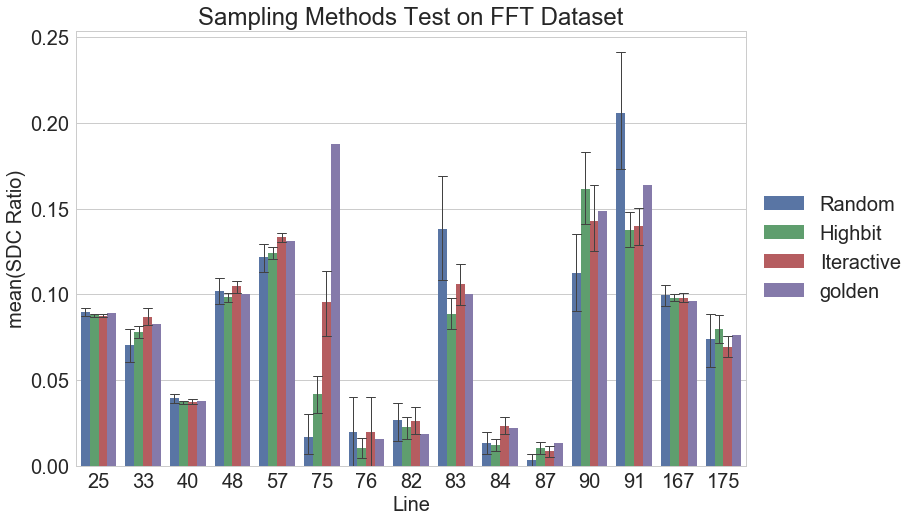

In [94]:
data = []

def parseDataToFrameFormat(data, category):
    arrays = []
    for key in data:
        for value in data[key]:
            arrays.append([key, value, category])
    return arrays 

data = data + parseDataToFrameFormat(each_line_sdc_ratio_distribution_random, 'Random')
data = data + parseDataToFrameFormat(each_line_sdc_ratio_distribution_hightbit, 'Highbit')
data = data + parseDataToFrameFormat(each_line_sdc_ratio_distribution_iterative, 'Iteractive')

for i in range(len(golden_sdc_label)):
    data.append([golden_sdc_label[i], golden_sdc[i], 'golden'])

sns.set(style="whitegrid")
plt.rcParams["axes.labelsize"] = 20
plt.rc('xtick', labelsize=20)     
plt.rc('ytick', labelsize=20)

df = pd.DataFrame(data, columns=['Line', 'mean(SDC Ratio)', 'Category'])
#print (df)
plt.figure(figsize=[12, 8])
plt.title('Sampling Methods Test on Conjugate Gradient Dataset', fontsize=24)
sns.set(font_scale=1.5) 
ax = sns.barplot(x="Line", y="mean(SDC Ratio)", hue="Category", data=df, errwidth=1, capsize=0.2, ci=68)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=20)
plt.show()

# SDC Impact

C:\Users\zhimin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


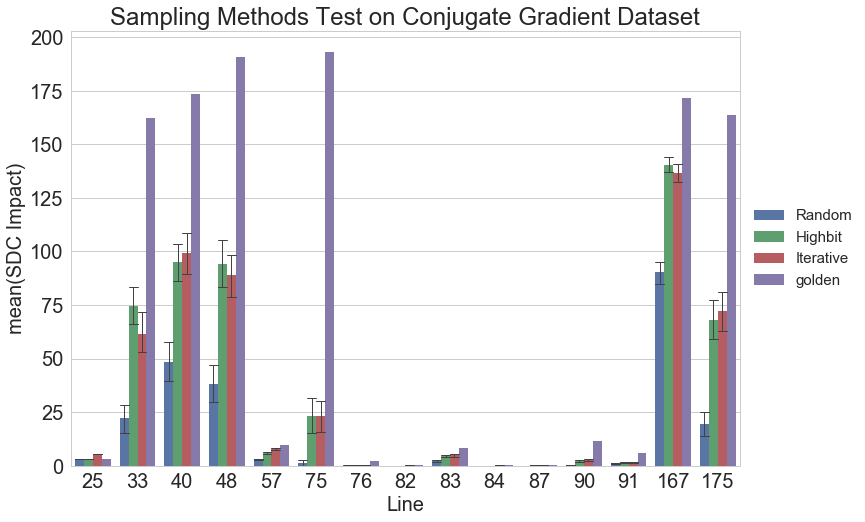

In [96]:
data = []

def parseDataToFrameFormat(data, category):
    arrays = []
    for key in data:
        for value in data[key]:
            arrays.append([key, value, category])
    return arrays 

data = data + parseDataToFrameFormat(each_line_expected_sdc_impact_distribution_random, 'Random')
data = data + parseDataToFrameFormat(each_line_expected_sdc_impact_distribution_highbit, 'Highbit')
data = data + parseDataToFrameFormat(each_line_expected_sdc_impact_distribution_iterative, 'Iterative')

for i in range(len(golden_sdc_label)):
    data.append([golden_sdc_label[i], golden_impact[i], 'golden'])

df = pd.DataFrame(data, columns=['Line', 'mean(SDC Impact)', 'Category'])

sns.set(style="whitegrid")
plt.rcParams["axes.labelsize"] = 20
plt.rc('xtick', labelsize=20)     
plt.rc('ytick', labelsize=20)

plt.figure(figsize=[12, 8])
plt.title('Sampling Methods Test on Conjugate Gradient Dataset', fontsize=24)

sns.set(font_scale=1.5) 
ax = sns.barplot(x="Line", y="mean(SDC Impact)", hue="Category", data=df, errwidth=1, capsize=0.2, ci=68)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()
#plt.savefig("test.svg", format="svg")